# Research on uses car service - Rusty Bargain

* Rusty Bargain used car sales service is developing an app to attract new customers. 


* In that app, you can quickly find out the market value of your car. 


* You have access to historical data: technical specifications, trim versions, and prices. 


* <b><font color='red'>You need to build the model to determine the value.</font></b>



* Rusty Bargain is interested in:

  - the quality of the prediction;
  - the speed of the prediction;
  - the time required for training

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from scipy.spatial import distance
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

## Data preparation

In [2]:
df = pd.read_csv('datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.rename(columns={'datecrawled':'date_crawled','vehicletype':'vehicle_type','registrationyear':'registration_year',
                   'registrationmonth':'registration_month','fueltype':'fuel_type','notrepaired':'not_repaired',
                   'datecreated':'date_created','numberofpictures':'number_of_pictures',
                   'postalcode':'postal_code','lastseen':'last_seen'}, inplace=True)

In [5]:
df.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
327452,14/03/2016 13:38,1200,sedan,2000,manual,101,vectra,125000,5,petrol,opel,NaN,14/03/2016 00:00,0,46117,14/03/2016 13:38
287846,10/03/2016 10:52,12750,small,2015,manual,82,c1,10000,3,petrol,citroen,no,10/03/2016 00:00,0,52355,07/04/2016 00:16
104779,26/03/2016 18:36,550,convertible,1997,manual,120,other,125000,0,NaN,rover,yes,26/03/2016 00:00,0,64668,06/04/2016 07:44
109512,15/03/2016 11:37,750,wagon,1998,manual,101,astra,150000,3,petrol,opel,no,15/03/2016 00:00,0,68305,15/03/2016 11:37
229248,22/03/2016 10:39,350,sedan,1995,manual,125,a4,150000,0,NaN,audi,yes,22/03/2016 00:00,0,41334,29/03/2016 12:46
116763,06/03/2016 00:49,3400,suv,1981,manual,45,NaN,40000,7,gasoline,sonstige_autos,no,05/03/2016 00:00,0,98553,05/04/2016 20:46
50173,02/04/2016 19:52,0,NaN,2005,NaN,0,leon,150000,0,NaN,seat,NaN,02/04/2016 00:00,0,56295,06/04/2016 20:17
72128,15/03/2016 18:56,700,small,1998,manual,50,polo,125000,3,petrol,volkswagen,yes,15/03/2016 00:00,0,65510,06/04/2016 22:44
276272,15/03/2016 00:52,18000,sedan,2008,auto,239,phaeton,125000,11,gasoline,volkswagen,no,14/03/2016 00:00,0,97337,05/04/2016 13:17
223677,27/03/2016 19:54,3500,convertible,2002,auto,75,fortwo,150000,5,petrol,smart,NaN,27/03/2016 00:00,0,41236,05/04/2016 18:45


In [6]:
df[["date_crawled", "date_created", "last_seen"]] = df[["date_crawled", "date_created", "last_seen"]].apply(pd.to_datetime,errors='coerce')
df[["date_crawled", "date_created", "last_seen"]] = df[["date_crawled", "date_created", "last_seen"]].apply(pd.to_numeric,errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  int64 
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  int64 
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  int64 
dtypes:

<h3>Data processing</h3>

In [7]:
df_size = df.shape[0]

print('Null values: {0:.2%}'.format(df.isna().any(axis=1).sum()/df_size))

Null values: 30.63%


In [8]:

(df.isna()).sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

* There are 30% rows with null values, removing them can not be considered at all and that is due to the high percentage of them.
* Can not fill these attributes because they are not a predictible values 
* There is a possibility that a user check price of a vehicle without having enough data, thus it is important to keep entries with missing values for these cases the result will be accordingly 

In [9]:
df['not_repaired'].value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

In [10]:
df['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

In [11]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [12]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [13]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

**dropping th ecolumn 'number_of_pictures' all of the rows have the same value zero, it does not has any weight on predicting results or analyzing them**

In [14]:
df.drop(['number_of_pictures'], inplace=True, axis=1)

<h3>EDA</h3>

In [15]:
print(df.describe())

       date_crawled          price  registration_year          power  \
count  3.543690e+05  354369.000000      354369.000000  354369.000000   
mean   1.461748e+18    4416.656776        2004.234448     110.094337   
std    6.935373e+15    4514.158514          90.227958     189.850405   
min    1.451866e+18       0.000000        1000.000000       0.000000   
25%    1.458251e+18    1050.000000        1999.000000      69.000000   
50%    1.458943e+18    2700.000000        2003.000000     105.000000   
75%    1.462298e+18    6400.000000        2008.000000     143.000000   
max    1.480810e+18   20000.000000        9999.000000   20000.000000   

             mileage  registration_month  date_created    postal_code  \
count  354369.000000       354369.000000  3.543690e+05  354369.000000   
mean   128211.172535            5.714645  1.461665e+18   50508.689087   
std     37905.341530            3.726421  6.938293e+15   25783.096248   
min      5000.000000            0.000000  1.412294e+18    1

* There is outliers values in the columns: price (zeros), registeration_year (9999), registeration_month (zeros)
* removing these values below

In [16]:

index_names = df[df['price'] < 100].index
df.drop(index_names , inplace=True)

index_names = df[df['registration_year'] > 2020].index
df.drop(index_names , inplace=True)

index_names = df[df['registration_year'] < 1000].index   #minumum year
df.drop(index_names , inplace=True)


index_names = df[df['power'] < 1].index   # minumum power
df.drop(index_names , inplace=True)

index_names = df[df['registration_month'] < 1].index
df.drop(index_names , inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286218 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        286218 non-null  int64 
 1   price               286218 non-null  int64 
 2   vehicle_type        270509 non-null  object
 3   registration_year   286218 non-null  int64 
 4   gearbox             282052 non-null  object
 5   power               286218 non-null  int64 
 6   model               276304 non-null  object
 7   mileage             286218 non-null  int64 
 8   registration_month  286218 non-null  int64 
 9   fuel_type           271693 non-null  object
 10  brand               286218 non-null  object
 11  not_repaired        249293 non-null  object
 12  date_created        286218 non-null  int64 
 13  postal_code         286218 non-null  int64 
 14  last_seen           286218 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 34.9+ MB


In [17]:
print(df.describe())

       date_crawled          price  registration_year          power  \
count  2.862180e+05  286218.000000      286218.000000  286218.000000   
mean   1.461746e+18    4992.684007        2003.388354     124.520240   
std    6.942082e+15    4629.494295           7.407444     183.901383   
min    1.451866e+18     100.000000        1000.000000       1.000000   
25%    1.458250e+18    1450.000000        1999.000000      77.000000   
50%    1.458946e+18    3350.000000        2004.000000     113.000000   
75%    1.462298e+18    7200.000000        2008.000000     150.000000   
max    1.480810e+18   20000.000000        2019.000000   20000.000000   

             mileage  registration_month  date_created    postal_code  \
count  286218.000000       286218.000000  2.862180e+05  286218.000000   
mean   127932.816944            6.381681  1.461661e+18   51307.335021   
std     36814.949563            3.347402  6.945014e+15   25734.857439   
min      5000.000000            1.000000  1.423613e+18    1

<h4>Observing Data Distribution</h4>

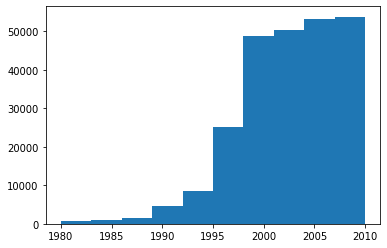

In [18]:
plt.hist(df['registration_year'],range=(1980, 2010))
plt.show()

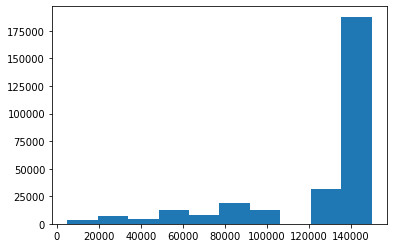

In [19]:
plt.hist(df['mileage'])
plt.show()

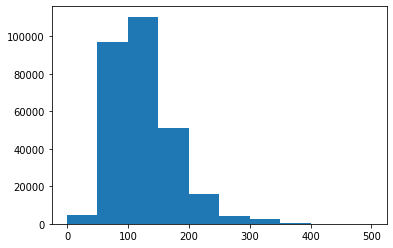

In [20]:
plt.hist(df['power'],range=(0, 500))
plt.show()

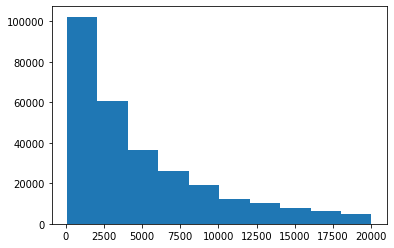

In [21]:
plt.hist(df['price'])
plt.show()

<h3>OHE Encoding</h3>

In [22]:
ohe_encoding = ['gearbox','not_repaired','vehicle_type','model','fuel_type','brand']
data_ohe = pd.get_dummies(df[ohe_encoding],dummy_na=True, drop_first=True)
df_ohe = df.join(data_ohe).drop(ohe_encoding, axis=1)
df_ohe.head()

,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen,gearbox_manual,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,brand_nan
1,1458817080000000000,18300,2011,190,125000,5,1458777600000000000,66954,1467596760000000000,1,...,0,0,0,0,0,0,0,0,0,0
2,1457959920000000000,9800,2004,163,125000,8,1457913600000000000,90480,1462366020000000000,0,...,0,0,0,0,0,0,0,0,0,0
3,1458233640000000000,1500,2001,75,150000,6,1458172800000000000,91074,1458236400000000000,1,...,0,0,0,0,0,0,0,1,0,0
4,1459445100000000000,3600,2008,69,90000,7,1459382400000000000,60437,1465035420000000000,1,...,1,0,0,0,0,0,0,0,0,0
5,1459791360000000000,650,1995,102,150000,10,1459728000000000000,33775,1465067820000000000,1,...,0,0,0,0,0,0,0,0,0,0


* Memory usage increased significantly after scaling the data 
* used downcasting in order to decrease memory usage 
  * tiny decrease

<h3>Splitting data</h3>

* Drop columns:
  * date_crawled
  * date_created 
  * last_seen
  * postal_code
* These attributes above are irrelevant to the price calculation/prediction, they have no affect or weight on the value of the price

In [23]:
X = df.drop(['price','date_crawled','date_created','last_seen','postal_code'], axis=1)
y = df['price']

In [24]:
X_ohe = df_ohe.drop(['price','date_crawled','date_created','last_seen','postal_code'], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [26]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y, test_size=0.3, random_state=12345)

In [27]:
def avg_dictionary(scores):
    avg_scores = dict()
    for elem in scores:
        avg_scores[elem] = np.mean(scores[elem])
        avg_scores[elem] = np.round(avg_scores[elem],decimals=3)
    return avg_scores

In [28]:
def std_dictionary(scores):
    std_scores = dict()
    for elem in scores:
        std_scores[elem] = np.std(scores[elem])
        std_scores[elem] = np.round(std_scores[elem],decimals=3)
    return std_scores        

In [29]:
def rmse_regressor(y_true, y_pred):    
    score_is  = sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False)
    return score_is  

**Using pipeline in order to do the scaling for the training set and validation set on each fold, is in order to avoid data leakage**

In [30]:
# cross validation method with 2 functions for scoring return dictionary 
custom_scorer = {
                 'score_r2_is': 'r2',
    'rmse': make_scorer(rmse_regressor),
    
                 }
def cross_val(model,features_train, target_train, cv_num,jobs):
    pipe_model = Pipeline([('scl', sklearn.preprocessing.MaxAbsScaler()),
                    ('clf', model)])
    res_scores = cross_validate(pipe_model,features_train, target_train,scoring=custom_scorer, cv=cv_num,n_jobs=jobs)
    res_scores = dict((k, abs(v)) for k, v in res_scores.items())
    avg_dict = avg_dictionary(res_scores)
    std_dict = std_dictionary(res_scores)
    print('mean: ')
    print(avg_dict)
    print('std: ')
    print(std_dict)

<h3>Sanity check - Linear Regression</h3>

In [31]:
%%time
lr = LinearRegression()
lr_scores = cross_val(lr,X_train_ohe, y_train_ohe,10,1)
print(lr_scores)

mean: 
{'fit_time': 16.439, 'score_time': 0.184, 'test_score_r2_is': 0.607, 'test_rmse': 2897.414}
std: 
{'fit_time': 0.69, 'score_time': 0.018, 'test_score_r2_is': 0.046, 'test_rmse': 163.487}
None
CPU times: total: 4min 38s
Wall time: 2min 46s


* Here we see:
  * total time is very short
  * R2 score is low 
  * RMSE value significantly high
* Linear regression works fast, but in our case it is not reliable

<h3>Random Forest</h3>

In [32]:
%%time
estimators_arr = [85,100,150]
best_scores = []
for i in estimators_arr:
    rfc = RandomForestRegressor(random_state=42,n_estimators = i)
    rfc_scores = cross_val(rfc,X_train_ohe, y_train_ohe,2,-1)
    print(rfc_scores)

mean: 
{'fit_time': 432.442, 'score_time': 11.71, 'test_score_r2_is': 0.868, 'test_rmse': 1679.233}
std: 
{'fit_time': 3.527, 'score_time': 0.639, 'test_score_r2_is': 0.001, 'test_rmse': 8.932}
None
mean: 
{'fit_time': 514.447, 'score_time': 13.865, 'test_score_r2_is': 0.869, 'test_rmse': 1677.873}
std: 
{'fit_time': 3.698, 'score_time': 0.554, 'test_score_r2_is': 0.002, 'test_rmse': 9.744}
None
mean: 
{'fit_time': 779.666, 'score_time': 21.99, 'test_score_r2_is': 0.869, 'test_rmse': 1675.646}
std: 
{'fit_time': 6.002, 'score_time': 1.087, 'test_score_r2_is': 0.002, 'test_rmse': 9.693}
None
CPU times: total: 719 ms
Wall time: 29min 55s


* For the Random Foret model with hyperparameter tuning:
  * Long fitting time 
  * Highest R2 score and lowest RMSE value occur when estimators number = 150, and on the first split 
  * Metrics results are very similar in the three cases
* Random Forest can be considered a reliable model however it requires a long time
* Using 2 fold for time saving purposes only

<h3>LightGBM</h3>

In [33]:
%%time
num_iters = [100,500,1000]
learn_rate = [0.1,0.3,0.5]
for i in range(3):
    lgb = LGBMRegressor(random_seed=12345,n_estimators = num_iters[i] ,learning_rate = learn_rate[i])
    lgb_scores = cross_val(lgb,X_train_ohe, y_train_ohe,5,-1)
    print(lgb_scores)

mean: 
{'fit_time': 14.749, 'score_time': 1.818, 'test_score_r2_is': 0.864, 'test_rmse': 1707.979}
std: 
{'fit_time': 2.055, 'score_time': 0.339, 'test_score_r2_is': 0.002, 'test_rmse': 8.506}
None
mean: 
{'fit_time': 23.172, 'score_time': 10.763, 'test_score_r2_is': 0.884, 'test_rmse': 1579.516}
std: 
{'fit_time': 5.416, 'score_time': 3.747, 'test_score_r2_is': 0.002, 'test_rmse': 7.174}
None
mean: 
{'fit_time': 28.013, 'score_time': 27.577, 'test_score_r2_is': 0.88, 'test_rmse': 1605.701}
std: 
{'fit_time': 5.752, 'score_time': 5.882, 'test_score_r2_is': 0.002, 'test_rmse': 6.726}
None
CPU times: total: 891 ms
Wall time: 3min


* For the LightGBM model with hyperparameter tuning:
   * short fitting time, low rmse, high r2 scores
   * highest R2 score and lowest RMSE value occur when estimators number = 500 learning rate = 0.3
   * Metrics results are slightly different from each other in the three cases 
* So far LightGBM can be considered as the best model: save time and reliable    

<h3>CatBoost</h3>

In [34]:
%%time
num_iters = [100,500,1000]
learn_rate = [0.1,0.3,0.5]
for i in range(3):
    cbt = CatBoostRegressor(random_seed=12345,silent=True,iterations = num_iters[i] ,learning_rate = learn_rate[i])
    cbt_scores = cross_val(cbt,X_train_ohe, y_train_ohe,5,-1)
    print(cbt_scores)

mean: 
{'fit_time': 19.0, 'score_time': 0.455, 'test_score_r2_is': 0.842, 'test_rmse': 1841.063}
std: 
{'fit_time': 5.379, 'score_time': 0.075, 'test_score_r2_is': 0.002, 'test_rmse': 10.831}
None
mean: 
{'fit_time': 56.576, 'score_time': 0.812, 'test_score_r2_is': 0.88, 'test_rmse': 1600.553}
std: 
{'fit_time': 16.098, 'score_time': 0.212, 'test_score_r2_is': 0.002, 'test_rmse': 7.806}
None
mean: 
{'fit_time': 101.683, 'score_time': 0.783, 'test_score_r2_is': 0.884, 'test_rmse': 1579.013}
std: 
{'fit_time': 29.246, 'score_time': 0.185, 'test_score_r2_is': 0.002, 'test_rmse': 9.968}
None
CPU times: total: 766 ms
Wall time: 4min 44s


* For the CatBoost model with hyperparameter tuning:
  * short time, low R2 score values, high RMSE values 
  * highest R2 score and lowest RMSE occur when iteration number = 500, learning rate = 0.3 
  * Metrics results are different from each other in the three cases 
*  CatBoost does not require time and it is reliable, The RMSE values are a bit higher than these of the LightGBM except of the last entry

<h3>XGBoost</h3>

In [35]:
%%time
estimators_arr = [50,100,150]
for i in estimators_arr:
    xgb = XGBRegressor(random_state=12345, n_estimators=i)
    xgb_scores = cross_val(xgb,X_train_ohe, y_train_ohe,2,-1)
    print(xgb_scores)

mean: 
{'fit_time': 121.283, 'score_time': 5.388, 'test_score_r2_is': 0.861, 'test_rmse': 1726.807}
std: 
{'fit_time': 8.1, 'score_time': 0.906, 'test_score_r2_is': 0.001, 'test_rmse': 8.873}
None
mean: 
{'fit_time': 212.945, 'score_time': 5.673, 'test_score_r2_is': 0.867, 'test_rmse': 1686.119}
std: 
{'fit_time': 0.772, 'score_time': 0.135, 'test_score_r2_is': 0.002, 'test_rmse': 10.079}
None
mean: 
{'fit_time': 341.64, 'score_time': 5.334, 'test_score_r2_is': 0.871, 'test_rmse': 1665.737}
std: 
{'fit_time': 22.322, 'score_time': 0.318, 'test_score_r2_is': 0.002, 'test_rmse': 10.641}
None
CPU times: total: 562 ms
Wall time: 12min 4s


* For the XGBoost model with hyperparameter tuning: 
   * Long fitting time 
   * Highest R2 score and lowest RMSE value occur when estimators number 150, second split 
   * Metrics results are very similar in the three cases
* XGBoost requires time however can be considered reliable 

## Model analysis

<h3>Model Evaluation - Test set</h3>

In [36]:
lgb_test = LGBMRegressor(random_seed=12345)
pipe_model_test = Pipeline([('scl', sklearn.preprocessing.MaxAbsScaler()),
                    ('clf', lgb_test)])
pipe_model_test.fit(X_train_ohe,y_train_ohe)
y_predicted = pipe_model_test.predict(X_test_ohe)
r2_test_score = r2_score(y_test_ohe,y_predicted)
rmse_test = sklearn.metrics.mean_squared_error(y_test_ohe, y_predicted, squared=False)
print('Test R2 Score {0:2f}'.format(r2_test_score))
print('Test RMSE {0:2f}'.format(rmse_test))

Test R2 Score 0.867406
Test RMSE 1686.092553


* Getting great results for the test set 
  * R2 > 0.85 
  * RMSE < 1700
* Here we justify our choice above about the LightGBM model as the model with high performance and the best one here for this dataset

<h3>Conclusion</h3>

* LightGBM has the best performance in terms of metrics results and time consumption
* XGBoost and Random Forest have similar metrics results, the difference is in time consumption XGBoost is faster. Both are reliable 
* CatBoost fast and reliable, The LightGBM beats it only where the iteration number are low 
* On overall look the LightGBM has the best performance among the other models

* Ranking model in terms of metrics results and time consumption
  1. LightGBM - the best performance
  2. CatBoos
  3. XGBoost 
  4. RandomForest